# **Data science 2- Homework 2 solution**
***

In [85]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display,Markdown
import statsmodels.api as sm
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

In [ ]:
# define random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)

## **1. Load the "Individual household electric power consumption" dataset** 
***

First, we will load the dataset and observe it:

In [86]:
# first define datatypes for the columns
dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

'''
fetch the dataset (acknowledging that the seperator is ';' and missing values are marked as '?'
'''

file_path = 'household_power_consumption.txt'
power_consumption_df = pd.read_csv(file_path, sep=';',dtype=dtypes,na_values='?')
power_consumption_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


We can see that we have 9 features:
* Date
* Time
* Global_active_power
* Global_reactive_power
* Voltage
* Global_intensity
* Sub_metering_1
* Sub_metering_2
* Sub_metering_3

However, our target (active energy consumed every minute) is still not present in the dataset and needs to be calculated. Also, we would like to combine date and time to a one feature called: "datetime".

In [87]:
# combine date and time into datetime
power_consumption_df['Datetime'] = pd.to_datetime(power_consumption_df['Date'] + ' ' + power_consumption_df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set the datetime column as index
power_consumption_df.set_index('Datetime', inplace=True)

# Drop the original Date and TIme columns
power_consumption_df.drop(columns=['Date', 'Time'], inplace=True)
power_consumption_df['active_power_per_minute'] = (power_consumption_df['Global_active_power'] * 1000 / 60) - (power_consumption_df['Sub_metering_1'] + power_consumption_df['Sub_metering_2'] + power_consumption_df['Sub_metering_3'])
power_consumption_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,active_power_per_minute
Datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


## 2. **EDA**
***

### **Visualize time series trends**
*** 

We will first view the time series trends

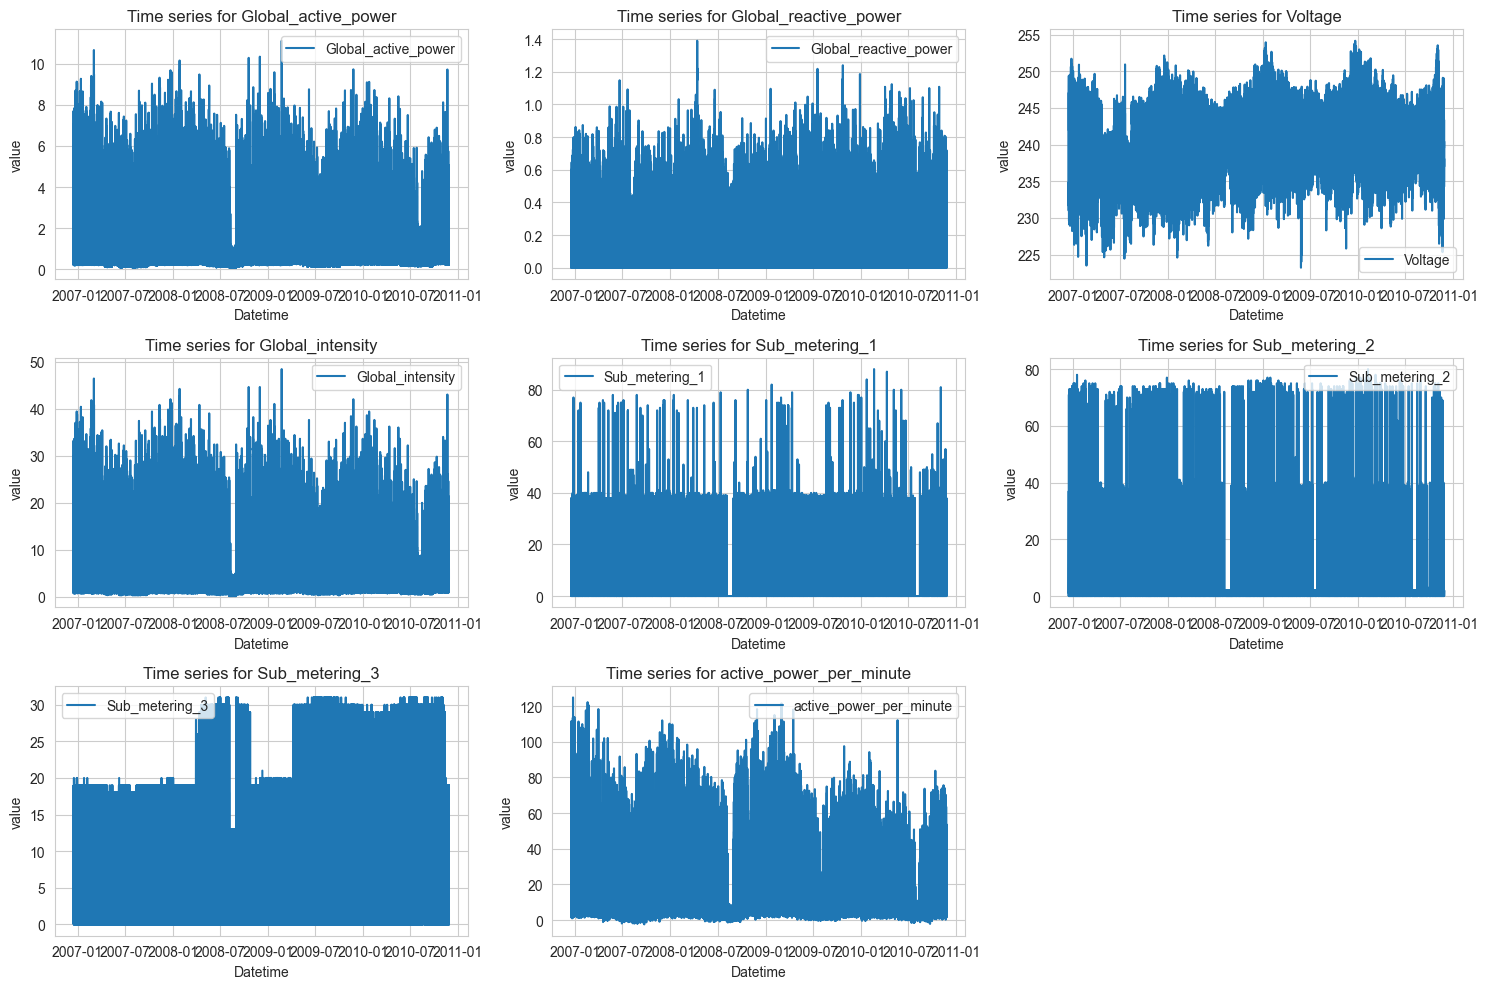

In [88]:
def visualize_time_trends(data,columns_to_omit=None,resample=None):
    num_plots = len(data.columns) - len(columns_to_omit) if columns_to_omit is not None else len(data.columns)
    num_rows = num_cols = math.ceil(math.sqrt(num_plots))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,10))
    if columns_to_omit is  None:
        columns_to_omit = []
        
    i = j = 0
    
    for column in data.columns:
        if column not in columns_to_omit:
            if resample is None:
                axes[i, j].plot(data[column], label=column)
                
            else:
                axes[i, j].plot(data[column].resample(resample).mean(), label=column)
                
            axes[i, j].set_title(f'Time series for {column}')
            axes[i, j].set_xlabel('Datetime')
            axes[i, j].set_ylabel(f"value")
            axes[i,j].legend()
            j += 1
            
            if j == num_cols:
                j = 0
                i += 1
                
    if math.sqrt(num_plots) < num_cols:
        axes[-1,-1].axis('off') # hide the last plot
    
    plt.tight_layout()
    plt.grid(True)
    plt.show()

visualize_time_trends(power_consumption_df)

let's try to resample the data to get some better visualization:


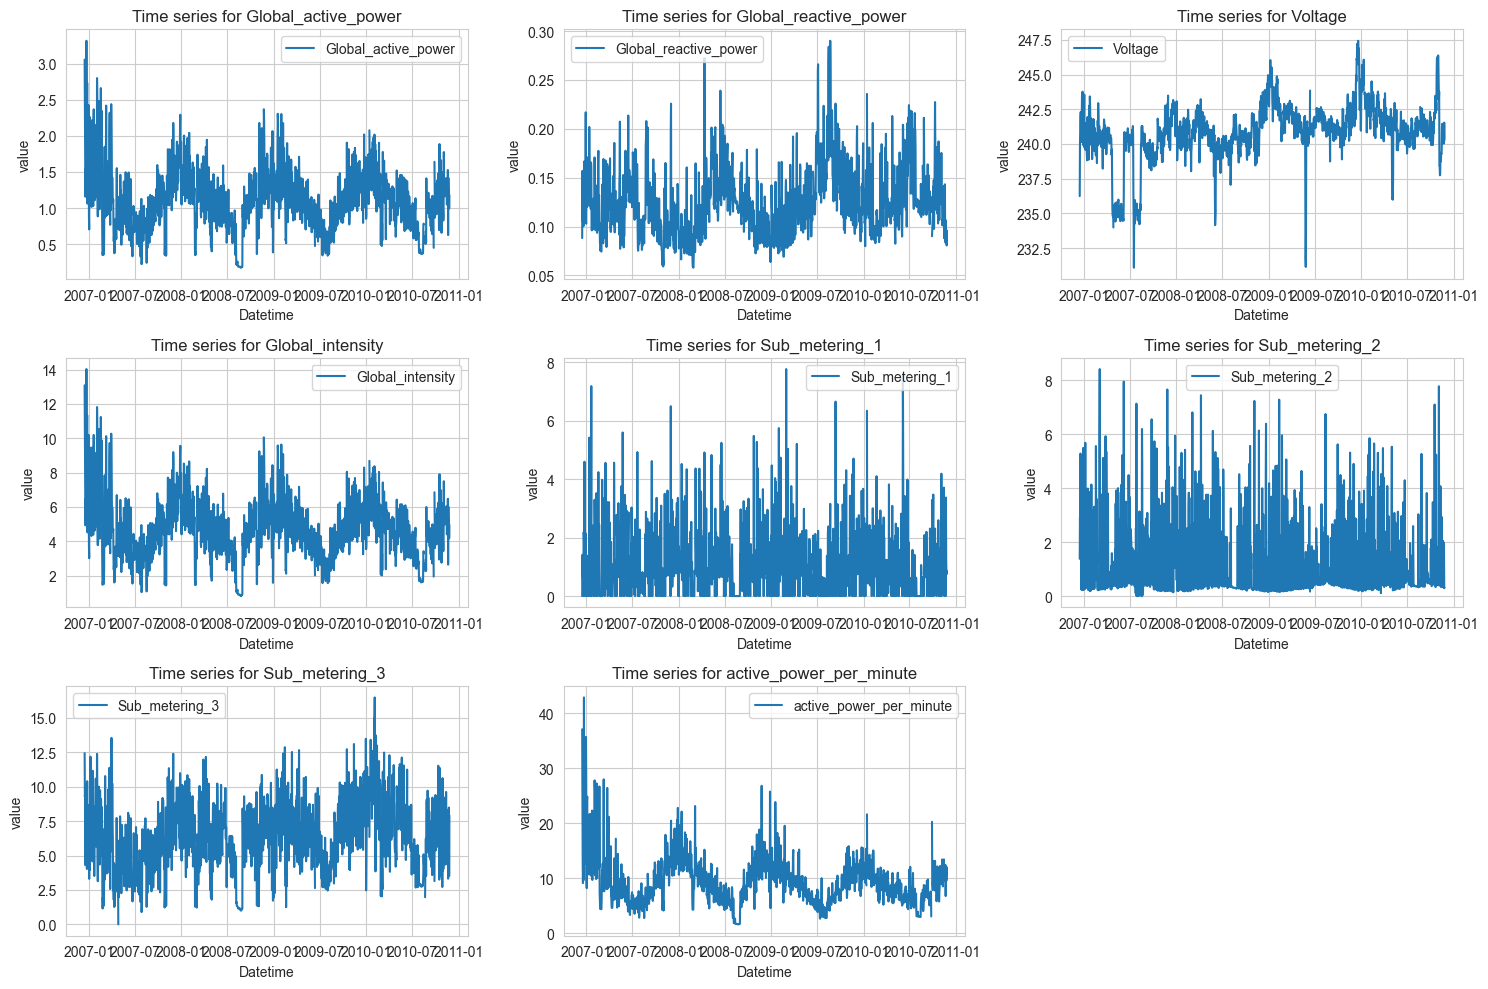

In [89]:
visualize_time_trends(data=power_consumption_df,resample='D')   # daily resampling

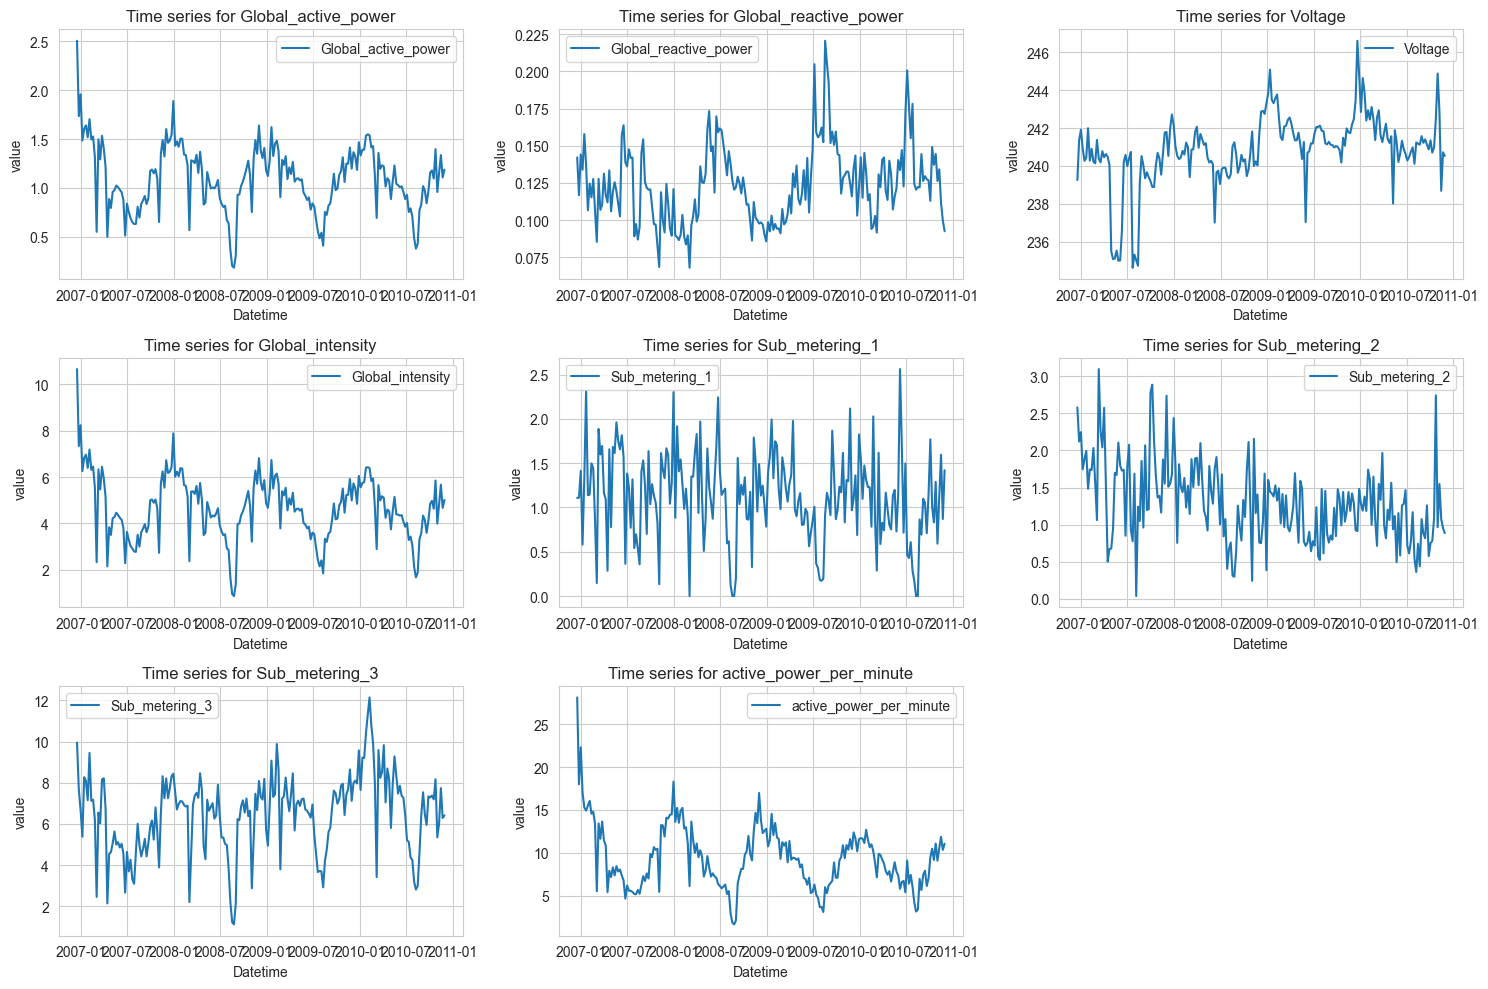

In [90]:
visualize_time_trends(data=power_consumption_df,resample='W')   # weekly resampling

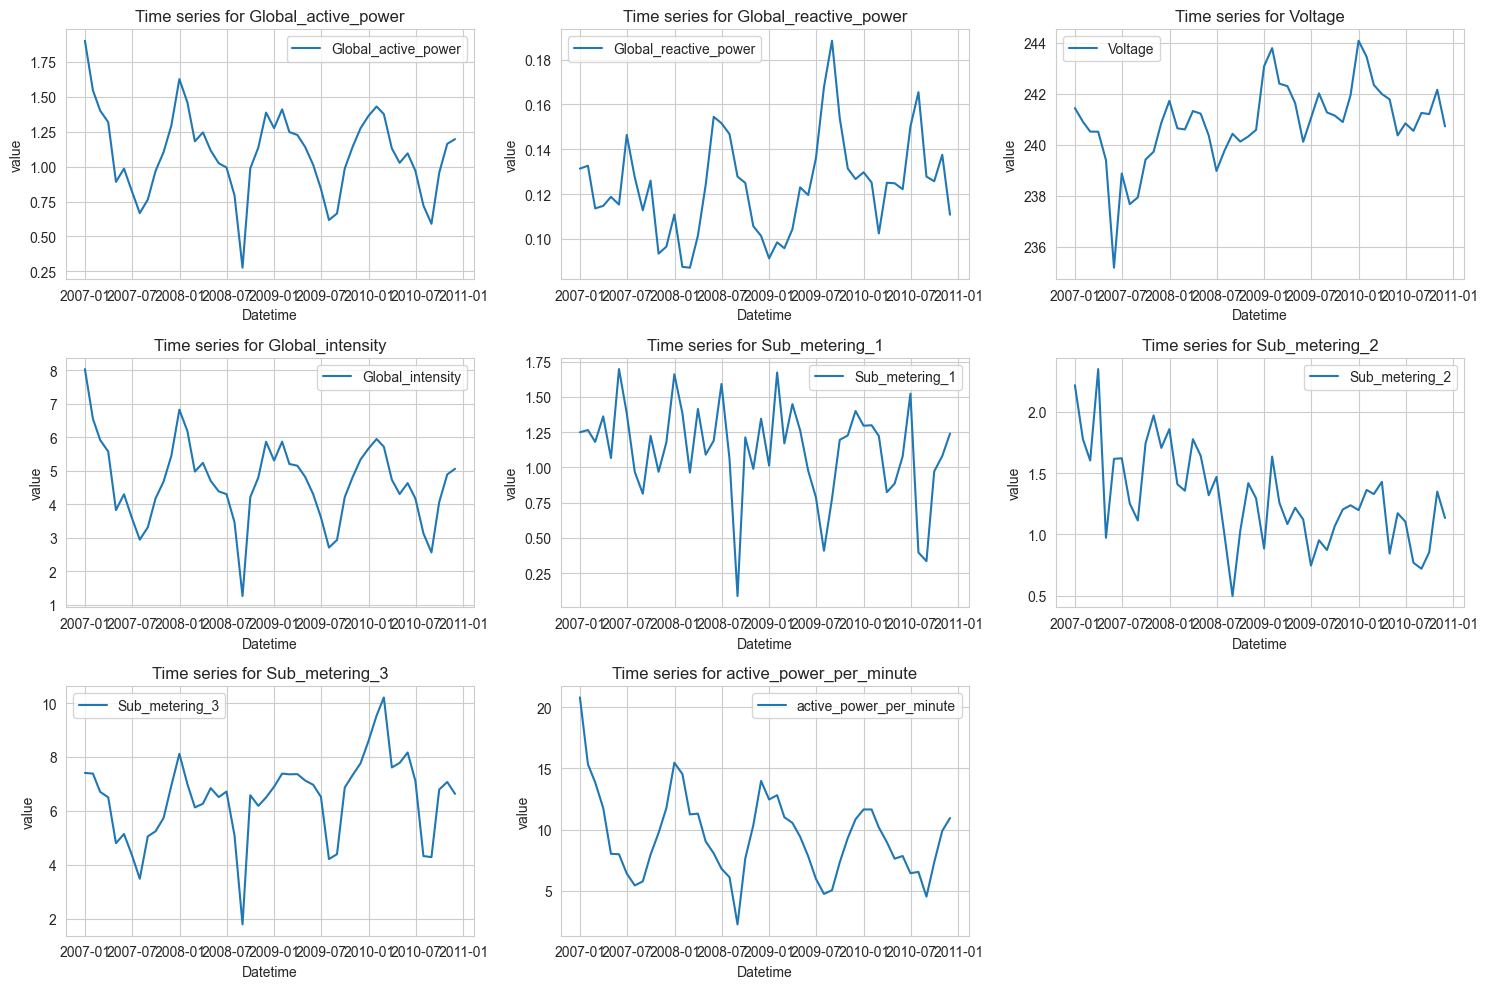

In [91]:
visualize_time_trends(data=power_consumption_df,resample='ME')   # monthly resampling

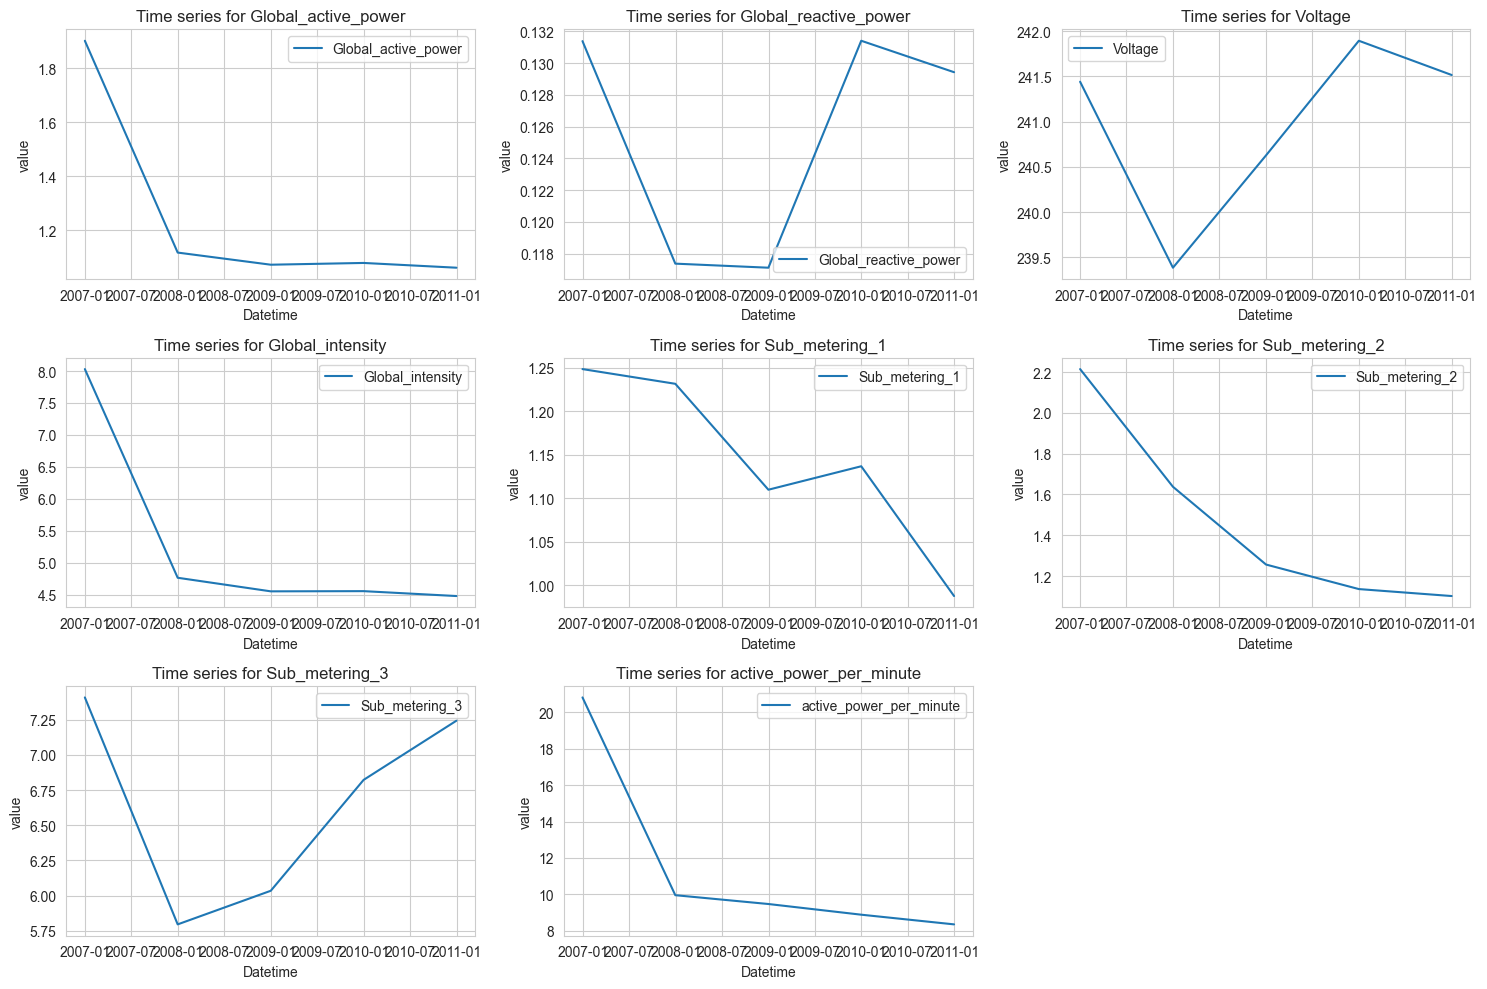

In [92]:
visualize_time_trends(data=power_consumption_df,resample='YE')   # annual resampling

### **Check for seasonality and cyclical patterns**
***

According to the time series trends we can say the following:
1. **Global Active Power**

    * **Seasonality:** It seems like there are strong seasonal patterns with regular peaks and troughs (best appeared in the monthly resampling). This phenomenon could be explained by high power consumption during certain times of the year (for example, hot summer days)
         
   * **Cyclical Patterns:** There may be some longer-term trends, but they are overshadowed and difficult to isolate from the clear seasonal patterns without further analysis.

2. **Global reactive power**
    * **Seasonality:** Similar to Global Active Power, we can see a strong seasonal pattern (which makes sense, since the reactive power are the losses from the electrical appliances of the consumer, so they should have the same seasonality as the active power)
      
    * **Cyclical Patterns:** The same as the active power - longer term trends are less apparent, since there is a strong seasonal pattern.

3. **Voltage** 
    * **Seasonality:** The voltage shows less clear seasonal patterns (it doesn't seem to have a constant period) compared to power consumption, though there are still some periodic fluctuations (it seems clearer in the weekly or monthly resampling)
      
    * **Cyclical Patterns:** If there are any cyclical patterns in the voltage, they are not very prominent.

4. **Global Intensity**
    * **Seasonality:** There is a clear seasonal pattern, with regular fluctuations which again could be explained by periods of higher electricity demand.
      
    * **Cyclical Patterns:** Similar to the Global Active Power, the cyclical trends are less evident due to the dominant seasonal patterns.

5. **Sub Metering 1,2, and 3:** 
    * **Seasonality:** Each sub metering shows distinct seasonal patterns, likely corresponding to specific appliances that have different regular usage cycles.
      
    * **Cyclical Patterns:** Less apparent, as the data is dominated by strong seasonal patterns.

6. **Active Power Per Minute**
    * **Seasonality:** There is a noticeable seasonal trend with regular peaks and troughs.
      
    *  **Cyclical Patterns:** Any cyclical trends are overshadowed by the strong seasonality.


**Conclusion**

This dataset exhibits strong seasonal patterns across most of the features, as well as the target variable (active power per minute). The seasonal patterns are consistent and predictable, and most likely correspond to higher and lower power demand during different periods of the year.

Cyclical patterns in this dataset are harder to distinguish from the seasonal ones, due to the dominance of the seasonal patterns.

### **Analyze distribution of power consumption**
***

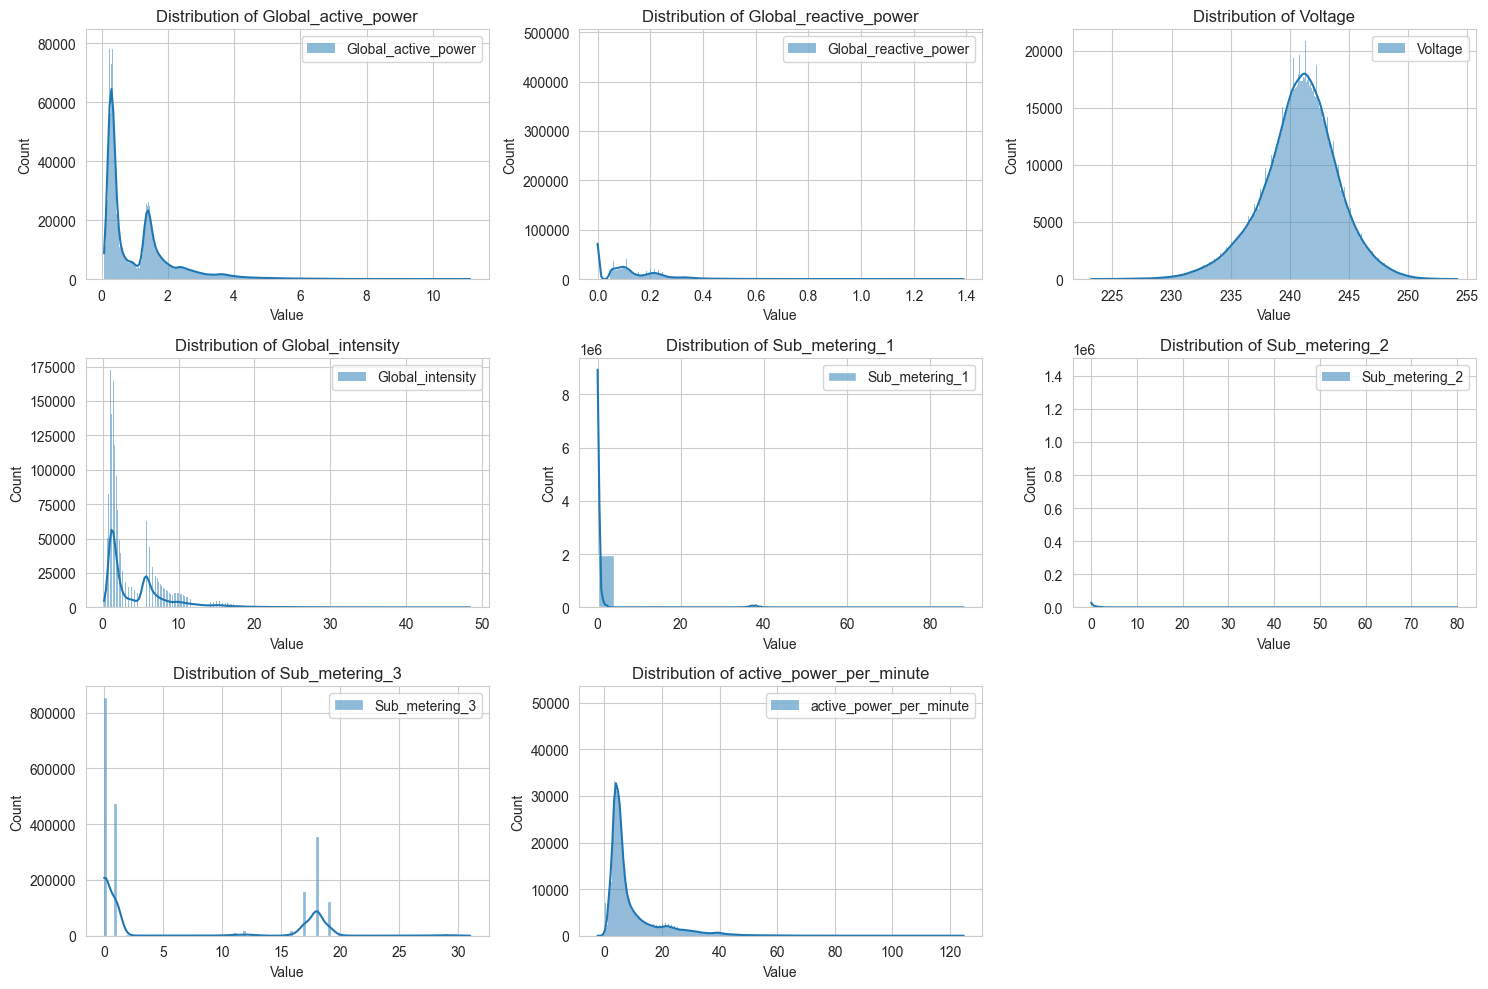

In [93]:
def visualize_distributions(data,columns_to_omit=None):
    num_plots = len(data.columns) - len(columns_to_omit) if columns_to_omit is not None else len(data.columns)
    num_rows = num_cols = math.ceil(math.sqrt(num_plots))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,10))
    
    if columns_to_omit is  None:
        columns_to_omit = []
        
    i = j = 0
    
    for column in data.columns:
        if column not in columns_to_omit:
            sns.histplot(x=data[column], label=column,kde=True,ax=axes[i,j])
            axes[i, j].set_title(f'Distribution of {column}')
            axes[i, j].set_xlabel('Value')
            axes[i, j].set_ylabel("Count")
            axes[i,j].legend()
            j += 1
            
            if j == num_cols:
                j = 0
                i += 1
                
    if math.sqrt(num_plots) < num_cols:
        axes[-1,-1].axis('off') # hide the last plot
    
    plt.tight_layout()
    plt.grid(True)
    plt.show()

visualize_distributions(data=power_consumption_df)

From the distributions we can draw the following conclusions:
* The Global Active power seems to be consisted of two different normal distributions, one centered near 0, and the other centered at approximately 1.7. That could imply some different seasonal patterns within the year, one with lower power consumption, and the other - with a higher one.

* The Global reactive power seems to be less sparse, and will most likely be near 0. It implies that the electricity network is efficient and doesn't suffer from many losses :) .

* The voltage is clearly normally distributed with a mean around 240V (which makes sense since it's a French household). The voltage consumption is sparse, and that could be explained by different voltage consumptions from different appliances.

* Just like Global Active Power, the Global Intensity also seems to be consisted of two normal distributions which can imply different seasonal patterns - one centered at approximately 0 and one centered at approximately 5 .

* Sub Metering 1 seems to be most likely near 0. It could imply that this type of appliance consume much less energy.
* Sub metering 2 seems to have much less value counts... It could imply that this column has missing values (we will check that right in the next cell).

* Sub Metering 3 seems to be more distributed. It has some peaks between 0 and 2 (most of the values lie there) but it also has a decent amount of values between 15-20. It could be interpreted either as a high power consumption period, or as outliers.

* Active power per minute seems slightly normally distributed, with a peak between 0 and 20 (let's say it's about 5...)

### **Identify and handle missing values and outliers**
***

First, let's check for missing values and where they lie (**Note:** we have already noticed that missing values are marked as '?', and made Pandas interpret that as N.A.):

In [94]:
display(power_consumption_df.isna().sum())
display(Markdown(f'##### {power_consumption_df.isna().sum().iloc[0]/ power_consumption_df.shape[0] * 100}% of the data is missing'))

Global_active_power        25979
Global_reactive_power      25979
Voltage                    25979
Global_intensity           25979
Sub_metering_1             25979
Sub_metering_2             25979
Sub_metering_3             25979
active_power_per_minute    25979
dtype: int64

##### 1.2518437457686005% of the data is missing

We can see that all the measurements columns has missing values, all with the same amount of missing values (25979 which is approximately 1.25% of the data, just as the dataset documentation described).

Now let's check for outliers:

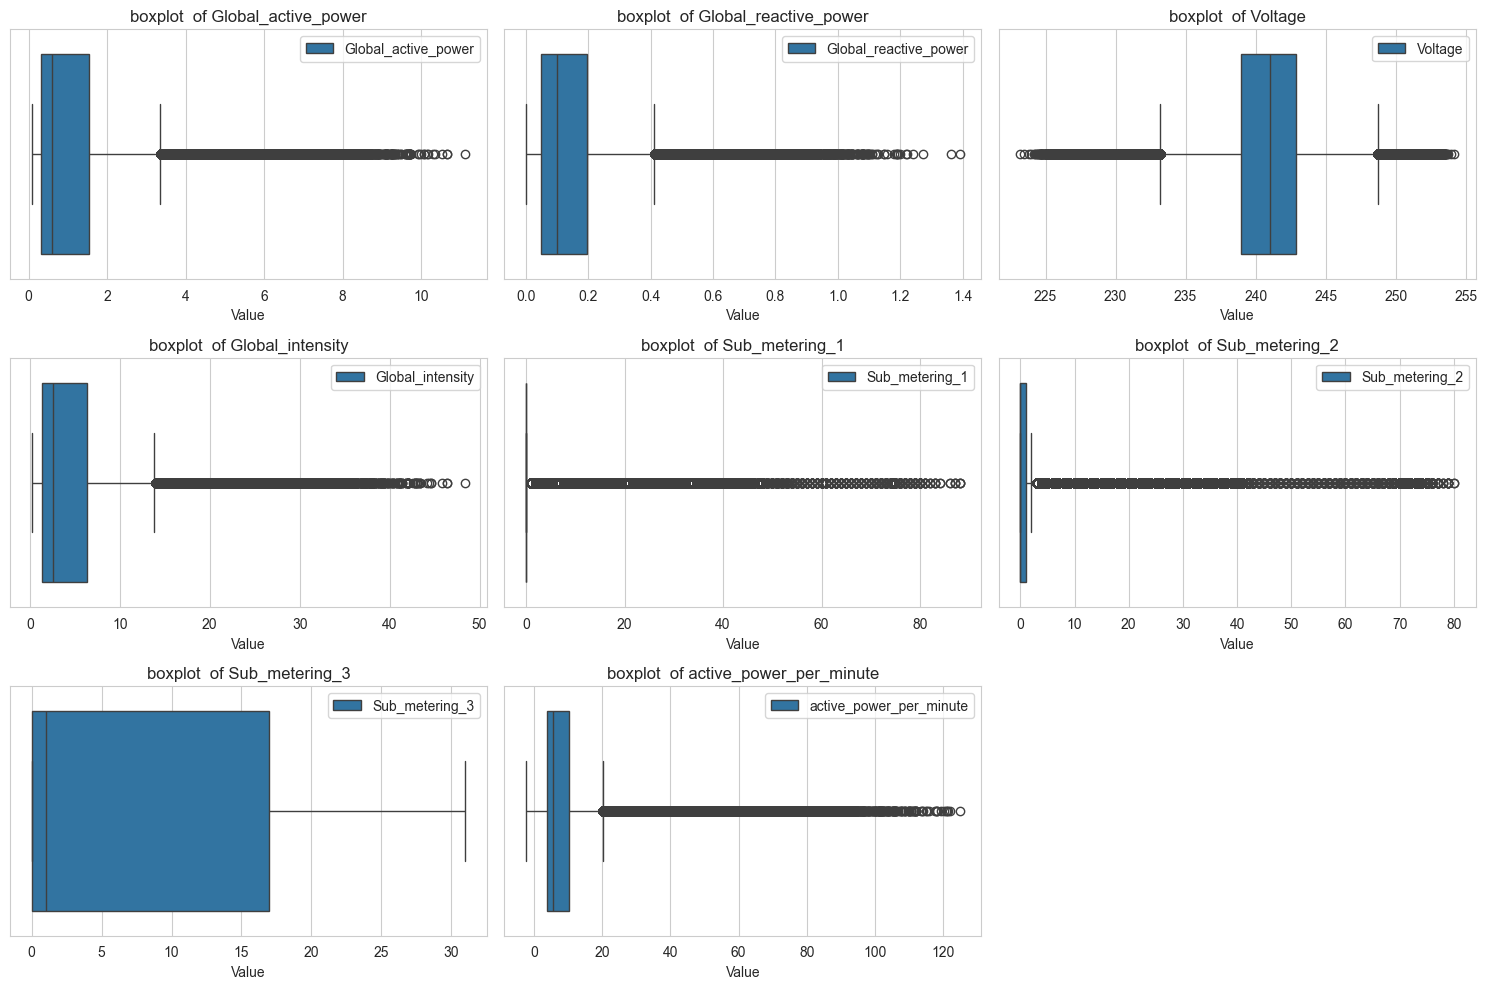

In [95]:
def visualize_boxplots(data,columns_to_omit=None):
    num_plots = len(data.columns) - len(columns_to_omit) if columns_to_omit is not None else len(data.columns)
    num_rows = num_cols = math.ceil(math.sqrt(num_plots))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,10))
    
    if columns_to_omit is  None:
        columns_to_omit = []
        
    i = j = 0
    
    for column in data.columns:
        if column not in columns_to_omit:
            sns.boxplot(x=data[column], label=column,ax=axes[i,j])
            axes[i, j].set_title(f'boxplot  of {column}')
            axes[i, j].set_xlabel('Value')
            axes[i,j].legend()
            j += 1
            
            if j == num_cols:
                j = 0
                i += 1
                
    if math.sqrt(num_plots) < num_cols:
        axes[-1,-1].axis('off') # hide the last plot
    
    plt.tight_layout()
    plt.grid(True)
    plt.show()

visualize_boxplots(data=power_consumption_df)

From the boxplots, we can see that the dataset has a lot of outliers. However, that could be explained by different seasonal patterns of power consumption within the year. Therefore, we wouldn't like to manipulate these outliers, on the contrary - we would like to use them in order to predict high / low power consumptions on certain periods during the year.

So, let's first handle the missing values. We will impute them using forward fill method. This method  will fill the missing values with the last observed value. First, since our target variable is calculated, we will remove it. Then, we will forward fill all the missing values, and only then - we will re-calculate our target variable (active power per minute)

In [96]:
power_consumption_df_no_missing = power_consumption_df.copy()
power_consumption_df_no_missing.drop(columns=['active_power_per_minute'],inplace=True)

for _column in power_consumption_df_no_missing.columns:
    # forward fill the column
    power_consumption_df_no_missing[_column] = power_consumption_df_no_missing[_column].ffill() 

# check for the existence of missing values again
power_consumption_df_no_missing.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Now that we have no missing values, let's re-calculate our target variable (active_power_per_minute):

In [97]:
power_consumption_df_no_missing['active_power_per_minute'] = (power_consumption_df_no_missing['Global_active_power'] * 1000 / 60) - (power_consumption_df_no_missing['Sub_metering_1'] + power_consumption_df_no_missing['Sub_metering_2'] + power_consumption_df_no_missing['Sub_metering_3'])
power_consumption_df_no_missing.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,active_power_per_minute
Datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


Now that we have filled the missing values and re-calculated our target. let's deal with the outliers. let's make a seasonal decomposition (for example, let's do that to the global_active_power):

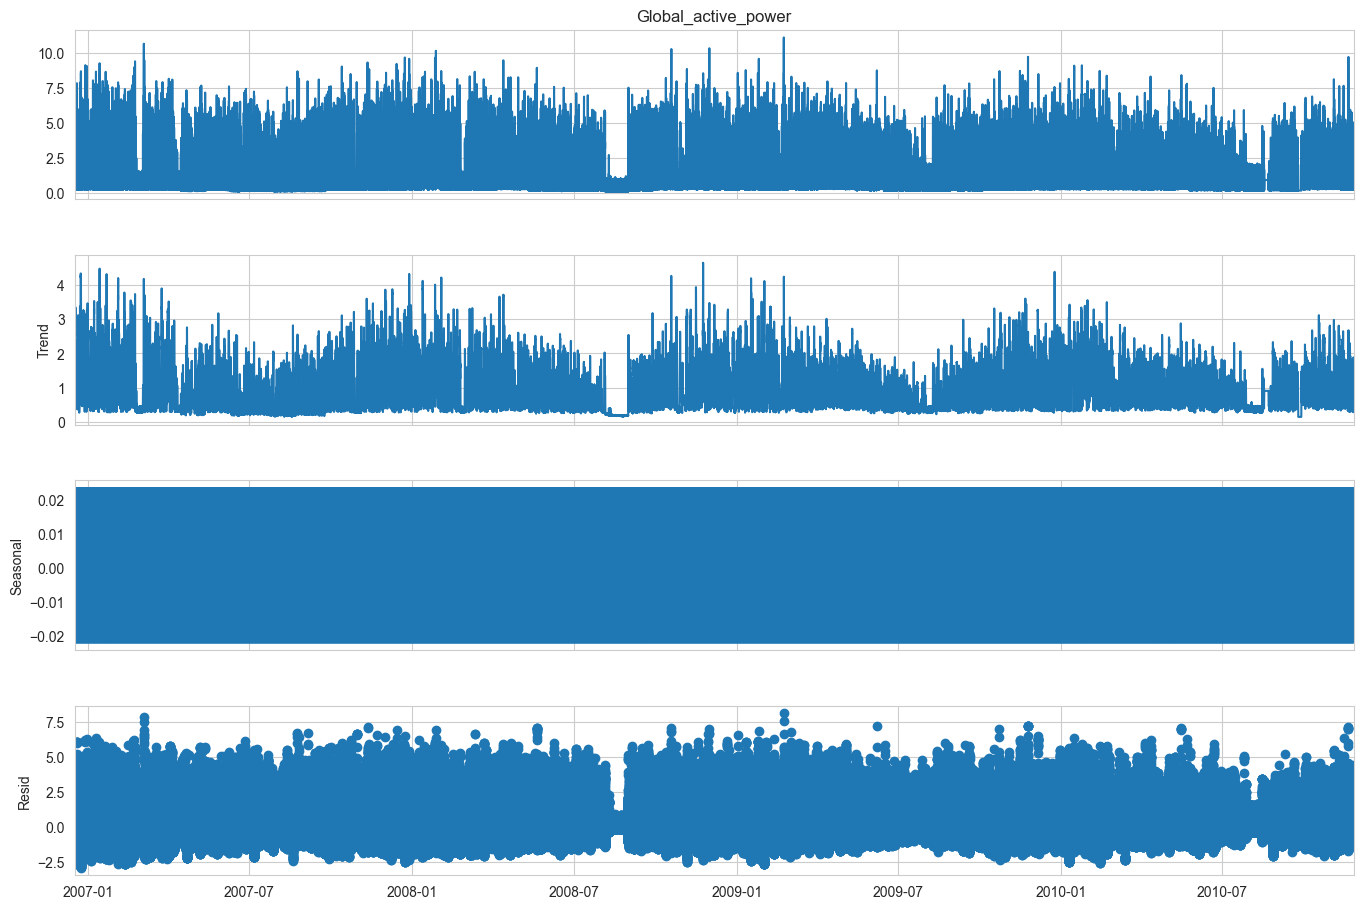

In [98]:
decomposition = sm.tsa.seasonal_decompose(power_consumption_df_no_missing['Global_active_power'],model='additive',period=365)
fig1 = decomposition.plot()
fig1.set_size_inches((15,10))
plt.show()

This decomposition consists of the following:
* **Observed:** The time series as it is (the actual data)
* **Trend:** reveals the long-term increase/decrease in the global_active_power consumption.
* **Seasonal:** The seasonal plot shows recurring patterns, for example: higher consumption during certain times of the month.
* **Residual:** The residual plot displays the noise or irregularities in the data (so we can use that in order to identify the outliers). We wil define an outlier as:
$outlier = resid.mean() \pm 3*resid.std()$
* We will check outliers for our target variable to see if it makes sense (for example - higher power consumption during summer). 

In [99]:
def check_for_outliers(time_series,period,number_of_stds):
    seasonal_decomposition = sm.tsa.seasonal_decompose(time_series,model='additive',period=period)
    residuals = seasonal_decomposition.resid
    outliers_high = residuals[(residuals > residuals.mean() + number_of_stds * residuals.std())]
    outliers_low = residuals[(residuals < residuals.mean() - number_of_stds * residuals.std())]
    return outliers_low.index, outliers_high.index
(low_outliers_dates, high_outliers_dates) = check_for_outliers(time_series=power_consumption_df_no_missing['active_power_per_minute'],period=365,number_of_stds=3)
display(Markdown(f'##### low_power consumption dates are: {low_outliers_dates}'))
display(Markdown(f'##### high_power consumption dates are: {high_outliers_dates}'))

##### low_power consumption dates are: DatetimeIndex(['2006-12-16 20:55:00', '2006-12-16 20:56:00',
               '2006-12-16 21:02:00', '2006-12-16 21:13:00',
               '2006-12-16 21:18:00', '2006-12-16 21:27:00',
               '2006-12-16 21:31:00', '2006-12-16 21:35:00',
               '2006-12-16 21:45:00', '2006-12-16 21:50:00',
               ...
               '2010-01-09 20:16:00', '2010-01-09 20:17:00',
               '2010-01-09 20:18:00', '2010-01-09 20:19:00',
               '2010-01-09 20:20:00', '2010-01-09 20:21:00',
               '2010-01-09 20:27:00', '2010-01-09 20:30:00',
               '2010-01-09 20:32:00', '2010-01-09 20:35:00'],
              dtype='datetime64[ns]', name='Datetime', length=1803, freq=None)

##### high_power consumption dates are: DatetimeIndex(['2006-12-16 23:50:00', '2006-12-16 23:51:00',
               '2006-12-16 23:52:00', '2006-12-17 01:03:00',
               '2006-12-17 01:04:00', '2006-12-17 01:05:00',
               '2006-12-17 01:08:00', '2006-12-17 01:09:00',
               '2006-12-17 01:13:00', '2006-12-17 01:14:00',
               ...
               '2010-11-26 07:37:00', '2010-11-26 07:38:00',
               '2010-11-26 07:39:00', '2010-11-26 07:40:00',
               '2010-11-26 07:41:00', '2010-11-26 07:49:00',
               '2010-11-26 12:07:00', '2010-11-26 12:08:00',
               '2010-11-26 16:49:00', '2010-11-26 16:53:00'],
              dtype='datetime64[ns]', name='Datetime', length=40215, freq=None)

let's see what percentage of the data are these outliers before we make a decision:

In [100]:
display(Markdown(f'##### {(len(low_outliers_dates) + len(high_outliers_dates)) / power_consumption_df_no_missing.shape[0] * 100}% of the data is considered outliers'))

##### 2.024711132441782% of the data is considered outliers

since only 2% of the data is considered outliers, we will decide to drop them:

In [101]:
power_consumption_df_no_missing_no_outliers = power_consumption_df_no_missing.copy()
outliers_to_drop = low_outliers_dates.union(high_outliers_dates)
power_consumption_df_no_missing_no_outliers.drop(outliers_to_drop,inplace=True)
display(power_consumption_df_no_missing_no_outliers)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,active_power_per_minute
Datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


## 3. **Implement a linear regression model**
***

### **Create lag variables**
***

In [106]:
def create_lag_variables_and_fill(dataframe,num_of_lags,columns_to_lag):
    for column in columns_to_lag:
        for i in range(1, num_of_lags + 1 , 1):
            dataframe[f'{column}_lag_{i}'] = dataframe[column].shift(i)
            dataframe[f'{column}_lag_{i}'].ffill()  # forward fill the created missing values
    

create_lag_variables_and_fill(power_consumption_df_no_missing_no_outliers,3,['Global_active_power']) 
display(power_consumption_df_no_missing_no_outliers)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,active_power_per_minute,Global_active_power_lag_1,Global_active_power_lag_2,Global_active_power_lag_3
Datetime,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667,NaN,NaN,NaN
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333,4.216,NaN,NaN
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667,5.360,4.216,NaN
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000,5.374,5.360,4.216
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000,5.388,5.374,5.360
...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667,0.946,0.942,0.946
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333,0.946,0.946,0.942
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333,0.944,0.946,0.946


## 4. **Evaluate the linear regression model**
***

In [ ]:
def evaluate_model(y_true,y_pred):
    return  pd.DataFrame({'MAE': mean_absolute_error(y_true, y_pred), 'MSE': mean_squared_error(y_true, y_pred), 'RMSE': root_mean_squared_error(y_true, y_pred), 'R^2': r2_score(y_true, y_pred)})